# Código Base
link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html

## Music Generation with RNNs

In [1]:
import tensorflow as tf 
import numpy as np
import os
import time
import regex as re
import subprocess
import urllib
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

c:\Users\nmhahn\anaconda3\envs\tcc\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


## Dataset

In [2]:
cwd = os.getcwd()

def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

songs = []

with open(os.path.join(cwd, 'data', 'irish', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)
    
# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [3]:
def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    suf = abc_file.rstrip('.abc')
    cmd = "abc2midi {} -o {}".format(abc_file, suf + ".mid")
    os.system(cmd)
    cmd = "timidity {}.mid -Ow {}.wav".format(suf, suf)
    return os.system(cmd) 

def play_wav(wav_file):
    return ipythondisplay.Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename + '.abc')
    if ret == 0: #did not suceed
        return play_wav(basename+'.wav')
    return None

In [4]:
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## Process the dataset for the learning task

In [5]:
# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [7]:
'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

    NOTE: the output of the `vectorize_string` function 
    should be a np.array with `N` elements, where `N` is
    the number of characters in the input string
'''

def vectorize_string(string):
    vectorized_list = np.array([char2idx[s] for s in string])
    return vectorized_list

vectorized_songs = vectorize_string(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


## Create training examples and targets

In [9]:
def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True

def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True

def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True

In [10]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1: i+1+seq_length] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not test_batch_func_types(get_batch, test_args) or \
   not test_batch_func_shapes(get_batch, test_args) or \
   not test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")


[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [11]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 82 ('|')
  expected output: 53 (']')
Step   1
  input: 53 (']')
  expected output: 2 ('!')
Step   2
  input: 2 ('!')
  expected output: 0 ('\n')
Step   3
  input: 0 ('\n')
  expected output: 0 ('\n')
Step   4
  input: 0 ('\n')
  expected output: 49 ('X')


## The Recurrent Neural Network (RNN) model

### Define the RNN model

In [12]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [13]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### Test out the model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [15]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Prediction from the untrained model

In [16]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 1, 72,  0, 66, 32,  1, 74, 75, 38, 63, 20, 14, 63, 56, 78, 46, 31,
        4, 58, 57, 72, 68, 80, 22, 68, 74, 81, 55, 44, 33, 35, 52, 10, 38,
       36, 14, 11, 58, 65, 38, 79, 80, 40, 16, 61, 53, 74, 26, 79, 32,  5,
       34, 67, 46, 81,  3, 80, 45, 74, 64, 61, 26, 75, 75, 52, 75,  4, 60,
       67, 51, 79, 33, 82, 63, 61, 18,  3, 72, 45, 76, 27, 28, 10, 37,  0,
       49, 18, 20, 80, 69, 80, 35,  4, 45,  7, 41, 37, 67, 60, 50],
      dtype=int64)

In [17]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 ":29\nT:Connaught Man's Rambles\nZ: id:dc-jig-23\nM:6/8\nL:1/8\nK:D Major\nA|FAA dAA|BAB dAG|FAA Afe|dBB B2"

Next Char Predictions: 
 ' q\nkG stMh82hawUF#cbqmy:msz_SHJ[.MK2/cjMxyO4f]sAxG\'IlUz"yTsifAtt[t#elZxH|hf6"qTuBC.L\nX68ynyJ#T)PLleY'


### Training the model: loss and training operations

In [18]:
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) 

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4185143


In [19]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [20]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

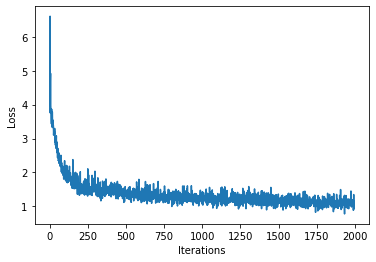

100%|██████████| 2000/2000 [18:47<00:00,  1.77it/s]


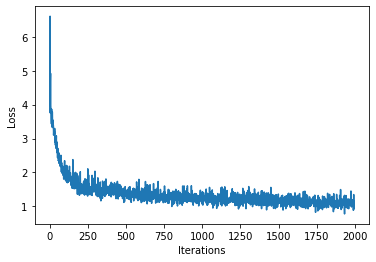

In [21]:
'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

#@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

### Restore the latest checkpoint

In [22]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### The prediction procedure

In [23]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [24]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s]


In [25]:
generated_songs = extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 5 songs in text


In [26]:
print(generated_text)

X:8O_,,,,_J,,_z,,_J,,,_z,._zfe age d2e|fga a2f|gag gfe|dBA def|ged edB|!
AGE G3|Add cdB|AGF G2:|!

X:185
T:Mich Twave ollan's
Z: id:dc-slipjig-10
M:9/8
L:1/8
K:E Minor
E|FAA Bed|cAA eAc|ABA edB|ABA ABc|dce fed|!
c3A GBdB|ABde fdde|!
fdcA dBGB|ABcA BcBA|FGFE D2:|!
A|ded d2e|fdf dfa|gfe dBd|eaa faa|ba fg|!
d2 dc BA|G3 A G2|F4 E2|F4 E2 G2 C2 C2:|!

X:12
T:Yish the Millies
Z: id:dc-slipjig-10
M:9/8
L:1/8
K:A Dorian
B|ABc d2e|dBG B2G|DGG BGG|]!

X:17
T:Planxhend -dBded|dee edf|gab bge|dcA B3|!
cAA cAA|e2f gec|d2A fge|dBA GEG|!
A,DD F2D2|c4 B2|c2 f2 A2|A2 GF DC|!
cA ec ec|ce ec/e/|dcB GBA|G3 G2:|!
Bc|dBd e^dB|AGF G2|]!

X:112
T:Johninage
Z: id:dc-reel-226
M:C
L:1/8
K:D Major
(3ABc|defd AGFE|DBed cBcd|eBBA f2fe|cBB B2A GFE|DED D2:|!
B|cde cee|dcB AFD|!
c3 d2|Ad cB AG|EG BG Bcd|BgB ABA|ABA G3:|!
K:D Major
A|d2c d2e|d2c ded|cBA BGF|!
DEF EGA|BAG AcG|AGG BAG|ABA AGF|!
GBd e3|dBd|age d2g|!


X:2t9
T:Humour
Z: id:dc-hornpipe-10
M:C|
L:1/8
K:A Major
E|D2DB, G,B,DE|DCDE GG EGEG|F2D2 ADFA|d3e cAA2:|!

In [27]:
print(generated_songs)

['X:8O_,,,,_J,,_z,,_J,,,_z,._zfe age d2e|fga a2f|gag gfe|dBA def|ged edB|!\nAGE G3|Add cdB|AGF G2:|!', "X:185\nT:Mich Twave ollan's\nZ: id:dc-slipjig-10\nM:9/8\nL:1/8\nK:E Minor\nE|FAA Bed|cAA eAc|ABA edB|ABA ABc|dce fed|!\nc3A GBdB|ABde fdde|!\nfdcA dBGB|ABcA BcBA|FGFE D2:|!\nA|ded d2e|fdf dfa|gfe dBd|eaa faa|ba fg|!\nd2 dc BA|G3 A G2|F4 E2|F4 E2 G2 C2 C2:|!", 'X:12\nT:Yish the Millies\nZ: id:dc-slipjig-10\nM:9/8\nL:1/8\nK:A Dorian\nB|ABc d2e|dBG B2G|DGG BGG|]!', 'X:17\nT:Planxhend -dBded|dee edf|gab bge|dcA B3|!\ncAA cAA|e2f gec|d2A fge|dBA GEG|!\nA,DD F2D2|c4 B2|c2 f2 A2|A2 GF DC|!\ncA ec ec|ce ec/e/|dcB GBA|G3 G2:|!\nBc|dBd e^dB|AGF G2|]!', 'X:112\nT:Johninage\nZ: id:dc-reel-226\nM:C\nL:1/8\nK:D Major\n(3ABc|defd AGFE|DBed cBcd|eBBA f2fe|cBB B2A GFE|DED D2:|!\nB|cde cee|dcB AFD|!\nc3 d2|Ad cB AG|EG BG Bcd|BgB ABA|ABA G3:|!\nK:D Major\nA|d2c d2e|d2c ded|cBA BGF|!\nDEF EGA|BAG AcG|AGG BAG|ABA AGF|!\nGBd e3|dBd|age d2g|!']
